<a href="https://colab.research.google.com/github/haonanzhang314/Machine-Learning/blob/master/chest_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#解压zip代码 !unzip "/content/drive/MyDrive/Colab Notebooks/chest/chest_xray.zip" -d "/content/drive/MyDrive/Colab Notebooks/chest/chest_xray"

--------------------------------------------------


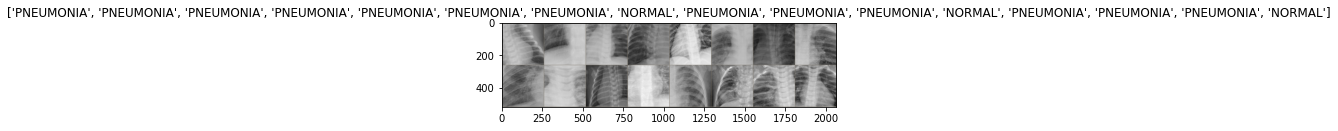

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

               Epoch |        Training Loss |            Test Loss |             Accuracy |


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test Loss : 0.8235, Accuracy : 12.0000
                   0 |    0.370549363592651 |   0.8234930038452148 |                12.00 |
Test Loss : 0.6877, Accuracy : 13.0000
                   1 |   0.2853357803213633 |   0.6876910328865051 |                13.00 |
Test Loss : 0.8272, Accuracy : 11.0000
                   2 |  0.24581399695959194 |   0.8271602392196655 |                11.00 |
Test Loss : 0.8255, Accuracy : 12.0000
                   3 |   0.2443270244709919 |   0.8254510164260864 |                12.00 |


In [ ]:
# 1 加入必要的库
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, utils, models
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
import os
import torchvision
import copy

# 2 加载数据集

# 2.1 图像变化设置
data_transforms = {
    "train":
        transforms.Compose([
            transforms.RandomResizedCrop(300),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),

    "val":
        transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),

    'test':
        transforms.Compose([
            transforms.Resize(size=300),
            transforms.CenterCrop(size=256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224,
                                                         0.225])
        ]),

}


# 3 可视化图片
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# 6 可视化模型预测

def visualize_model(model, num_images=6):
    """显示预测的图片结果
        Args:
            model: 训练后的模型
            num_images: 需要显示的图片数量

        Returns:
            无
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (datas, targets) in enumerate(dataloaders['val']):
            datas, targets = datas.to(device), targets.to(device)
            outputs = model(datas)  # 预测数据
            _, preds = torch.max(outputs, 1)  # 获取每行数据的最大值
            for j in range(datas.size()[0]):
                images_so_far += 1  # 累计图片数量
                ax = plt.subplot(num_images // 2, 2, images_so_far)  # 显示图片
                ax.axis('off')  # 关闭坐标轴
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(datas.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# 7 定义训练函数
def train(model, device, train_loader, criterion, optimizer, epoch, writer):
    # 作用：声明在模型训练时，采用Batch Normalization 和 Dropout
    # Batch Normalization : 对网络中间的每层进行归一化处理，保证每层所提取的特征分布不会被破坏
    # Dropout : 减少过拟合
    model.train()
    total_loss = 0.0  # 总损失初始化为0.0
    # 循环读取训练数据，更新模型参数
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # 梯度初始化为零
        output = model(data)  # 训练后的输出
        loss = criterion(output, target)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 参数更新
        total_loss += loss.item()  # 累计损失
    # 写入日志
    writer.add_scalar('Train Loss', total_loss / len(train_loader), epoch)
    writer.flush()  # 刷新
    return total_loss / len(train_loader)  # 返回平均损失值


# 8 定义测试函数
def test(model, device, test_loader, criterion, epoch, writer):
    # 作用：声明在模型训练时，不采用Batch Normalization 和 Dropout
    model.eval()
    # 损失和正确
    total_loss = 0.0
    correct = 0.0
    # 循环读取数据
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 预测输出
            output = model(data)
            # 计算损失
            total_loss += criterion(output, target).item()
            # 获取预测结果中每行数据概率最大的下标
            _, preds = torch.max(output, dim=1)
            # pred = output.data.max(1)[1]
            # 累计预测正确的个数
            correct += torch.sum(preds == target.data)
            # correct += pred.eq(target.data).cpu().sum()

            ######## 增加 #######
            misclassified_images(preds, writer, target, data, output, epoch)  # 记录错误分类的图片

        # 总损失
        total_loss /= len(test_loader)
        # 正确率
        accuracy = correct / len(test_loader)
        # 写入日志
        writer.add_scalar('Test Loss', total_loss, epoch)
        writer.add_scalar('Accuracy', accuracy, epoch)
        writer.flush()
        # 输出信息
        print("Test Loss : {:.4f}, Accuracy : {:.4f}".format(total_loss, accuracy))
        return total_loss, accuracy


# 定义函数，获取Tensorboard的writer
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter('logdir/' + timestr)
    return writer


# 8 模型微调

# 定义一个池化层处理函数
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, size=None):
        super().__init__()
        size = size or (1, 1)  # 池化层的卷积核大小，默认值为（1，1）
        self.pool_one = nn.AdaptiveAvgPool2d(size)  # 池化层1
        self.pool_two = nn.AdaptiveMaxPool2d(size)  # 池化层2

    def forward(self, x):
        return torch.cat([self.pool_one(x), self.pool_two(x)], 1)  # 连接两个池化层


def get_model():
    model_pre = models.resnet50(pretrained=True)  # 获取预训练模型

    # 冻结预训练模型中所有参数
    for param in model_pre.parameters():
        param.requires_grad = False

    # 替换ResNet最后的两层网络，返回一个新的模型（迁移学习）
    model_pre.avgpool = AdaptiveConcatPool2d()  # 池化层替换
    model_pre.fc = nn.Sequential(
        nn.Flatten(),  # 所有维度拉平
        nn.BatchNorm1d(4096),  # 正则化处理
        nn.Dropout(0.5),  # 丢掉神经元
        nn.Linear(4096, 512),  # 线性层处理
        nn.ReLU(),  # 激活函数
        nn.BatchNorm1d(512),  # 正则化处理
        nn.Dropout(p=0.5),  # 丢掉神经元
        nn.Linear(512, 2),  # 线性层
        nn.LogSoftmax(dim=1)  # 损失函数
    )
    return model_pre


def train_epochs(model, device, dataloaders, criterion, optimizer, num_epochs, writer):
    """
    Returns:
        返回一个训练过后最好的模型
    """
    print("{0:>20} | {1:>20} | {2:>20} | {3:>20} |".format('Epoch', 'Training Loss', 'Test Loss', 'Accuracy'))
    best_score = np.inf  # 假设最好的预测值
    start = time.time()  # 开始时间

    # 开始循环读取数据进行训练和验证
    for epoch in num_epochs:

        train_loss = train(model, device, dataloaders['train'], criterion, optimizer, epoch, writer)

        test_loss, accuracy = test(model, device, dataloaders['val'], criterion, epoch, writer)

        if test_loss < best_score:
            best_score = test_loss
            torch.save(model.state_dict(), model_path)  # 保存模型 # state_dict变量存放训练过程中需要学习的权重和偏置系数

        print("{0:>20} | {1:>20} | {2:>20} | {3:>20.2f} |".format(epoch, train_loss, test_loss, accuracy))

        writer.flush()

    # 训练完所耗费的总时间
    time_all = time.time() - start
    # 输出时间信息
    print("Training complete in {:.2f}m {:.2f}s".format(time_all // 60, time_all % 60))


def misclassified_images(pred, writer, target, data, output, epoch, count=10):
    misclassified = (pred != target.data)  # 记录预测值与真实值不同的True和False
    for index, image_tensor in enumerate(data[misclassified][:count]):
        # 显示预测不同的前10张图片
        img_name = '{}->Predict-{}x{}-Actual'.format(
            epoch,
            LABEL[pred[misclassified].tolist()[index]],
            LABEL[target.data[misclassified].tolist()[index]],
        )
        writer.add_image(img_name, inv_normalize(image_tensor), epoch)


# 9 训练和验证

# 定义超参数
model_path = 'model.pth'
batch_size = 16
# gpu和cpu选择
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2.2 加载数据 .\表示当前层目录 ..\表示上一层目录   #colab中最好填写绝对路径 /content/drive/......这种
data_path ='/content/drive/MyDrive/Colab Notebooks/chest/chest_x/chest_xray'


# 2.2.1 加载数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in
                  ['train', 'val', 'test']}

# 2.2.2 为数据集创建iterator
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

# 2.2.3 训练集和验证集的大小
data_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# 2.2.4 训练集所对应的标签
class_names = image_datasets['train'].classes  # 一共有2个：NORMAL正常 vs PNEUMONIA肺炎
LABEL = dict((v, k) for k, v in image_datasets['train'].class_to_idx.items())

print("-" * 50)

# 4 获取trian中的一批数据
datas, targets = next(iter(dataloaders['train']))

# 5 显示这批数据
out = torchvision.utils.make_grid(datas)

imshow(out, title=[class_names[x] for x in targets])

# 将tensor转换为image
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.255]
)

writer = tb_writer()
images, labels = next(iter(dataloaders['train']))  # 获取一批数据
grid = torchvision.utils.make_grid([inv_normalize(image) for image in images[:32]])  # 读取32张图片
writer.add_image('X-Ray grid', grid, 0)  # 添加到TensorBoard
writer.flush()  # 将数据读取到存储器中

model = get_model().to(device)  # 获取模型
criterion = nn.NLLLoss()  # 损失函数
optimizer = optim.Adam(model.parameters())
train_epochs(model, device, dataloaders, criterion, optimizer, range(0, 10), writer)
writer.close()

